In [1]:
!pip install numpy tensorflow scikit-learn matplotlib seaborn keras

In [2]:
# -------------------- Imports --------------------

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import random
import keras
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# -------------------- Config --------------------

DATA_DIR = "./dataset/plantvillage-dataset/color"
BEST_MODEL_DIR = "./model-checkpoints"
BEST_MODEL_NAME = "customCNN_best.keras"

TRAIN_SPLIT_RATIO = 0.8
VALIDATION_SPLIT_RATIO = 0.1
TEST_SPLIT_RATIO = 0.1

SEED = 123
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 40
EPOCHS = 20
PATIENCE = 3
LEARNING_RATE = 1e-3
LOSS_FUNCTION = 'categorical_crossentropy'

os.makedirs(BEST_MODEL_DIR, exist_ok=True)

In [4]:
# ------------------ Prepare file paths & labels ------------------

def get_image_paths_and_labels(data_dir):
    class_names = sorted(os.listdir(data_dir))
    all_image_paths = []
    all_labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        all_image_paths.extend(images)
        all_labels.extend([idx] * len(images))
    return all_image_paths, all_labels, class_names

all_image_paths, all_labels, class_names = get_image_paths_and_labels(DATA_DIR)
num_classes = len(class_names)

print(f"Found {len(all_image_paths)} images belonging to {num_classes} classes.")

Found 54305 images belonging to 38 classes.


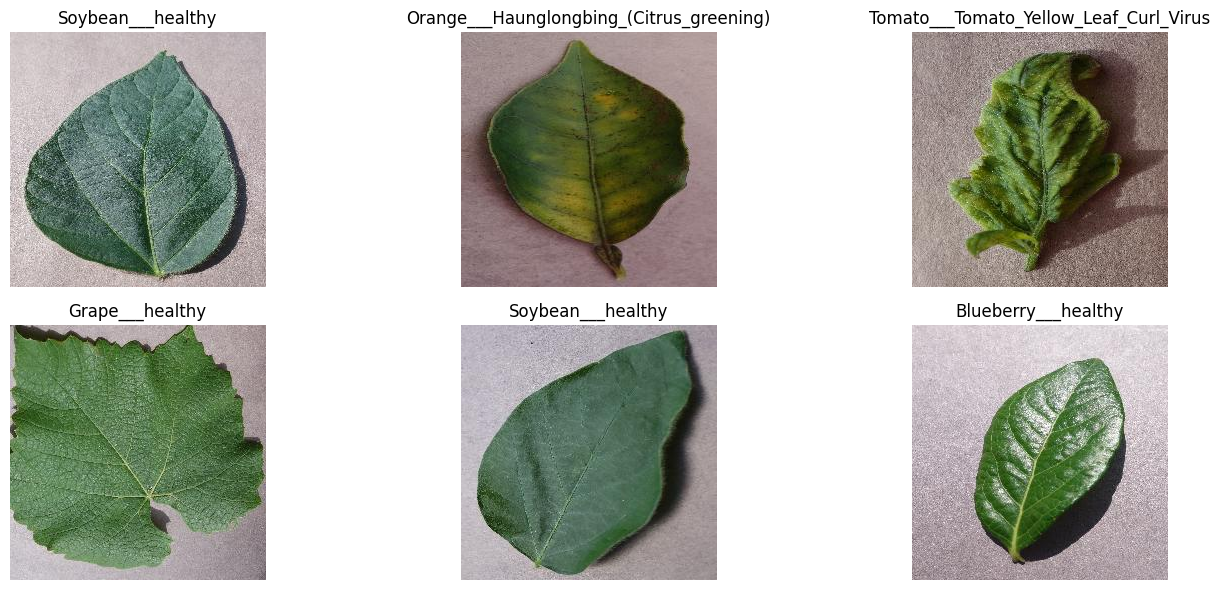

In [5]:
def show_random_samples(image_paths, labels, class_names, num_samples=5):
    samples = random.sample(list(zip(image_paths, labels)), num_samples)
    plt.figure(figsize=(15, 3 * ((num_samples + 2) // 3)))
    cols = 3
    for i, (img_path, label) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: unable to read {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot((num_samples + 2) // 3, cols, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_random_samples(all_image_paths, all_labels, class_names, num_samples=6)

In [6]:
# ------------------ Split dataset ------------------

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels,
    train_size=TRAIN_SPLIT_RATIO,
    random_state=SEED,
    stratify=all_labels
)

temp_ratio = TEST_SPLIT_RATIO / (VALIDATION_SPLIT_RATIO + TEST_SPLIT_RATIO)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=temp_ratio,
    random_state=SEED,
    stratify=temp_labels
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

print("Classes:")
for label in class_names:
    print(label)

Train: 43444, Val: 5430, Test: 5431
Classes:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___Powdery_mildew
Cherry_(including_sour)___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___Northern_Leaf_Blight
Corn_(maize)___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Peach___healthy
Pepper,_bell___Bacterial_spot
Pepper,_bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Raspberry___healthy
Soybean___healthy
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Strawberry___healthy
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_m

In [7]:
# ------------------ Dataset creation helper ------------------

def decode_and_resize(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img.set_shape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    return img, label

def process_path(file_path, label):
    img, label = decode_and_resize(file_path, label)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    label = tf.one_hot(label, num_classes)
    return img, label

def prepare_dataset(file_paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024, seed=SEED)
    if augment:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.08),
            layers.RandomZoom(0.12),
            layers.RandomContrast(0.08),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_paths, train_labels, shuffle=True, augment=True)
val_ds = prepare_dataset(val_paths, val_labels)
test_ds = prepare_dataset(test_paths, test_labels)

In [8]:
# ------------------ Build model ------------------

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (*IMAGE_SIZE,3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dense(64, activation='relu'),

    keras.layers.Dense(len(class_names), activation='softmax'),

])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=LOSS_FUNCTION,
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,734 (678.65 KB)

 Trainable params: 173,734 (678.65 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ------------------ Callbacks ------------------

callbacks = [
    ModelCheckpoint(os.path.join(BEST_MODEL_DIR, BEST_MODEL_NAME), save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE, verbose=1),
    EarlyStopping(monitor='val_loss', patience=PATIENCE*2, verbose=1, restore_best_weights=True)
]

In [10]:
# ------------------ Train ------------------

if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using CUDA device.")
else:
    print("GPU not available. Using CPU.")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

GPU is available. Using CUDA device.
Epoch 1/20
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 566s 510ms/step - accuracy: 0.2688 - loss: 2.9457 - precision: 0.6118 - recall: 0.1236 - val_accuracy: 0.5700 - val_loss: 1.4339 - val_precision: 0.7852 - val_recall: 0.4348 - learning_rate: 0.0010
Epoch 2/20
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 539s 495ms/step - accuracy: 0.6424 - loss: 1.1908 - precision: 0.8050 - recall: 0.5136 - val_accuracy: 0.7311 - val_loss: 0.8454 - val_precision: 0.8502 - val_recall: 0.6451 - learning_rate: 0.0010
Epoch 3/20
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 545s 500ms/step - accuracy: 0.7572 - loss: 0.7721 - precision: 0.8464 - recall: 0.6856 - val_accuracy: 0.8151 - val_loss: 0.5992 - val_precision: 0.8905 - val_recall: 0.7429 - learning_rate: 0.0010
Epoch 4/20
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 560s 499ms/step - accuracy: 0.8061 - loss: 0.6144 - precision: 0.8670 - recall: 0.7541 - val_accuracy: 0.7781 - val_loss: 0.7052 - val_precision: 0.8347 - val_recall: 0.7401 - learning_rate: 0.0010
Epo

In [11]:
# ------------------ Evaluate and get preds ------------------

print("Evaluating on test set...")
results = model.evaluate(test_ds)
print(f"Test results: {results}")

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

Evaluating on test set...
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9445 - loss: 0.1864 - precision: 0.9539 - recall: 0.9380
Test results: [0.1714516282081604, 0.9467869400978088, 0.9546641707420349, 0.9421837329864502]
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 924ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 

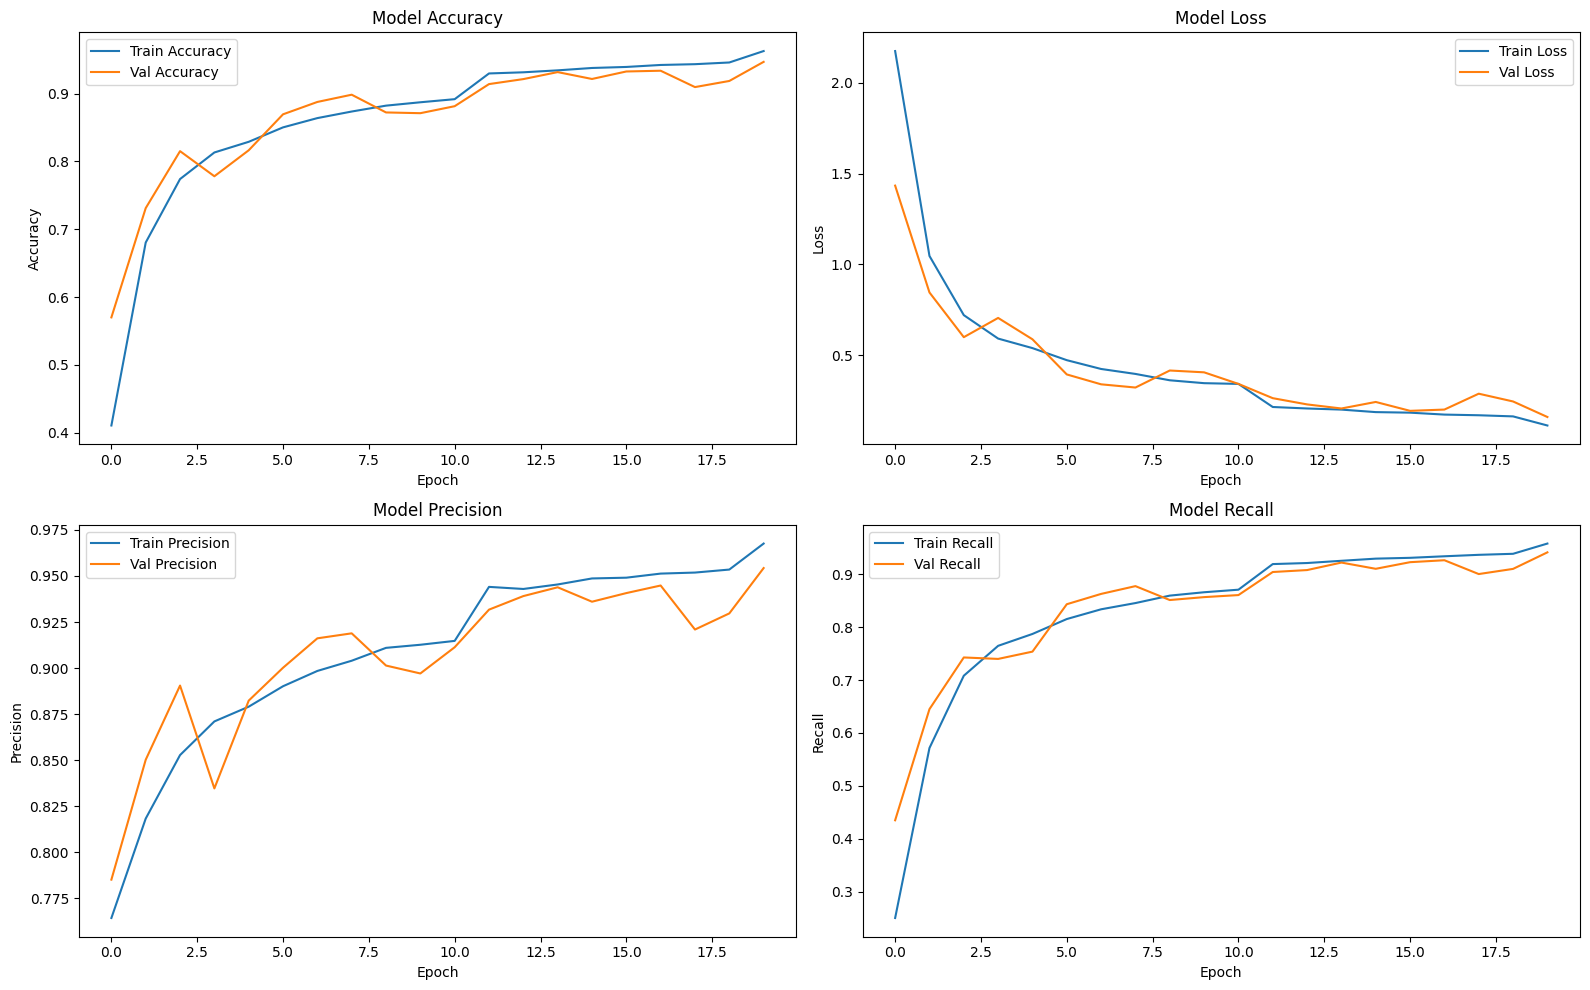

In [12]:
# ------------------ Plot precision, recall ------------------
def plot_full_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_full_metrics(history)

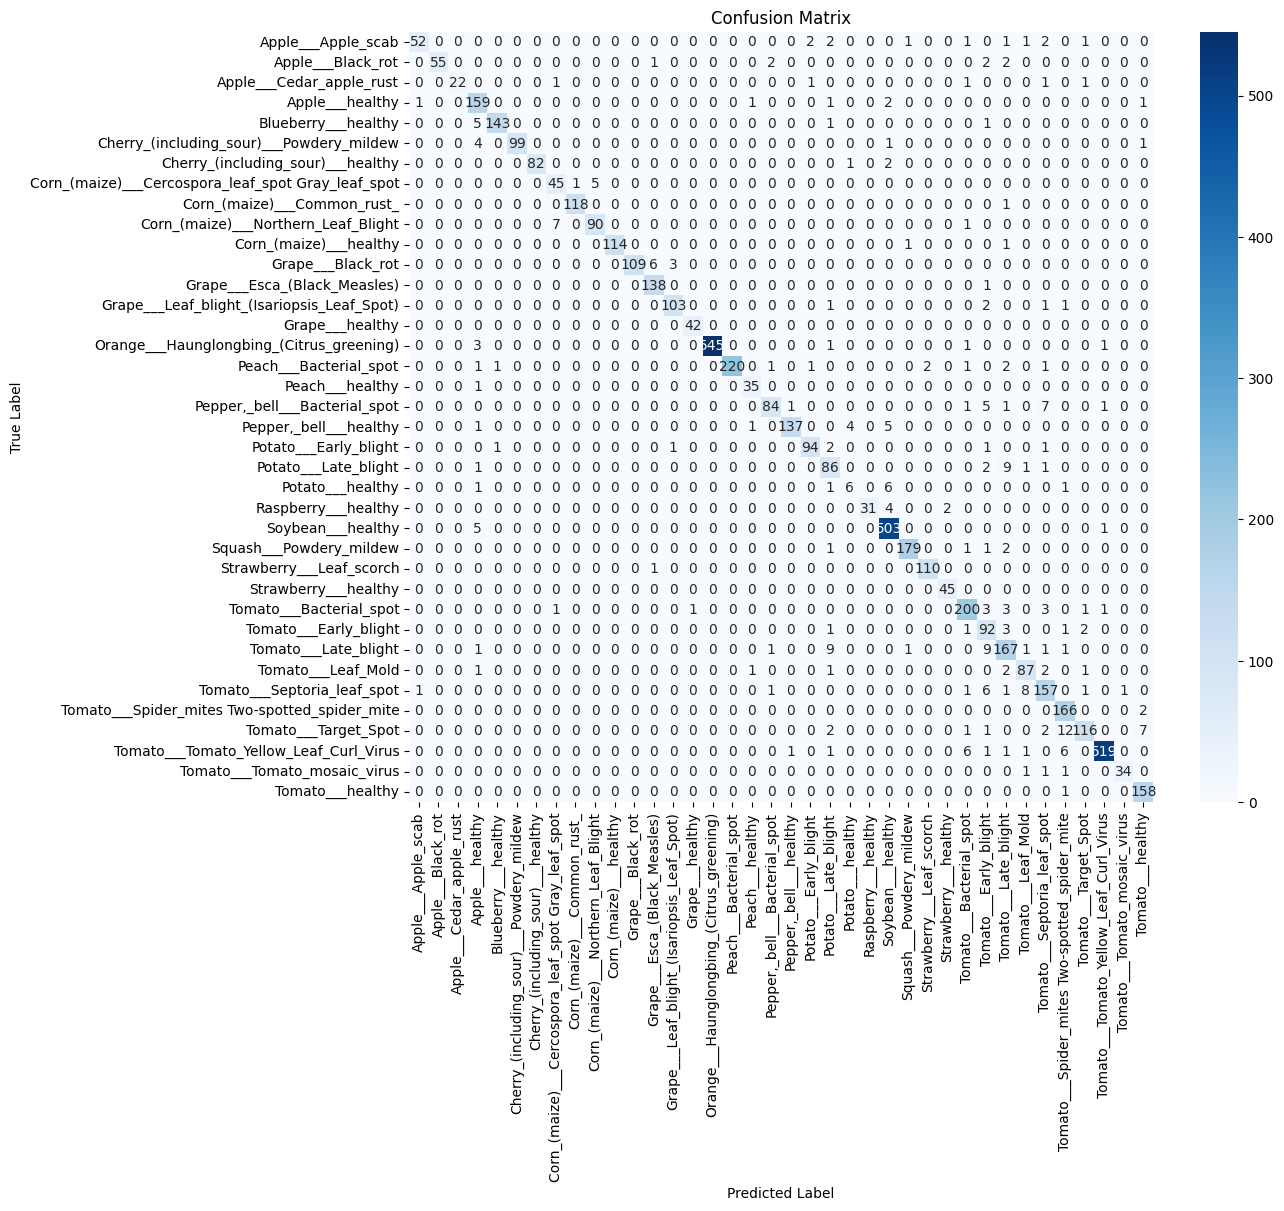

In [13]:
# ------------------ Confusion matrix plot ------------------

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# ------------------ Classifiaction report ------------------

ClassificationReport = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report is :\n ', ClassificationReport)

Classification Report is :
                                                      precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.83      0.89        63
                                 Apple___Black_rot       1.00      0.89      0.94        62
                          Apple___Cedar_apple_rust       1.00      0.81      0.90        27
                                   Apple___healthy       0.87      0.96      0.91       165
                               Blueberry___healthy       0.99      0.95      0.97       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.94      0.97       105
                 Cherry_(including_sour)___healthy       1.00      0.96      0.98        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.88      0.86        51
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       119
               Corn_(maize)___Northern_Leaf_Blight